# Homework 03 - Interactive Viz

#### Note: GitHub does not render maps. You can see the full notebook by using one of the following links:
- <https://dariopavllo.github.io/ada/homework3.html>
- <https://nbviewer.jupyter.org/github/dariopavllo/ada-homework/blob/master/03%20-%20Interactive%20Viz/homework3.ipynb>

In [1]:
import os
import pandas as pd
import json
import folium
import copy
from itertools import chain
import numpy as np
%matplotlib inline

## 1. Unemployment in Europe
We use the unemployment dataset downloaded from the [eurostat](http://ec.europa.eu/eurostat/data/database) website, which represents people aged between 15 and 74 years. This dataset reveals the unemployment figures across various countries in Europe in 2016. We could observe that the dataset contains information about the 28 countries of the European Union, as well as some additional countries, such as Switzerland.

In particular, the dataset contains the _unemployment rate_-that is, the number of unemployed people as a percentage of the labour force. The labour force is definied as the total number of employed and unemployed people. The exact definition of _unemployed person_ and _employed person_ can be found in the [explanatory text](http://ec.europa.eu/eurostat/cache/metadata/en/une_esms.htm) on the eurostat website. The rate is also [seasonally adjusted](https://en.wikipedia.org/wiki/Seasonal_adjustment).

In [2]:
# Load the data that contains the unemployment statistics in Europe
europe_unemploy_rate_path = 'datasets/europe_unemploy_2016.csv'; period = 2016
europe_unemploy_rate = pd.read_csv(europe_unemploy_rate_path)

# Select only the totals from the most recent period
europe_unemploy_rate = europe_unemploy_rate.loc[\
    (europe_unemploy_rate.TIME==period) & (europe_unemploy_rate.SEX=="Total") & (~europe_unemploy_rate.GEO.str.contains("European|Euro")), \
    ["GEO","Value"]]

# Since we need to merge this data with the TopoJSON data, we have to make sure that the country names are matched
europe_unemploy_rate.loc[europe_unemploy_rate.GEO.str.contains("Germany"), "GEO"] = "Germany"
europe_unemploy_rate.loc[europe_unemploy_rate.GEO.str.contains("Macedonia"), "GEO"] = "The former Yugoslav Republic of Macedonia"

print("The unemployment rate is available for", europe_unemploy_rate.shape[0], "states")

# Show first entries
europe_unemploy_rate.head(5)

The unemployment rate is available for 33 states


,GEO,Value
0,Belgium,7.8
1,Bulgaria,7.6
2,Czech Republic,4.0
3,Denmark,6.2
4,Germany,4.1


We draw the boundaries of the following states, contained in the TopoJSON file.

In [3]:
# Load the TopoJSON description of Europe, that defines the shape of the states
europe_topo_path = 'topojson/europe.topojson.json'
topo_data = json.load(open(europe_topo_path))
topo_states = [state["properties"]["NAME"] for state in topo_data["objects"]["europe"]["geometries"]]
print(len(topo_states), "states:", ", ".join(topo_states))

51 states: Azerbaijan, Albania, Armenia, Bosnia and Herzegovina, Bulgaria, Cyprus, Denmark, Ireland, Estonia, Austria, Czech Republic, Finland, France, Georgia, Germany, Greece, Croatia, Hungary, Iceland, Israel, Italy, Latvia, Belarus, Lithuania, Slovakia, Liechtenstein, The former Yugoslav Republic of Macedonia, Malta, Belgium, Faroe Islands, Andorra, Luxembourg, Monaco, Montenegro, Netherlands, Norway, Poland, Portugal, Romania, Republic of Moldova, Slovenia, Spain, Sweden, Switzerland, Turkey, United Kingdom, Ukraine, San Marino, Serbia, Holy See (Vatican City), Russia


And we check for which states the data is not available.

In [4]:
# The unemployment figures are not available for all states
missing_states = list(set(topo_states)-set(europe_unemploy_rate.GEO))
print("The unemployment rate of these", len(missing_states), "states is missing:", ", ".join(missing_states))

The unemployment rate of these 18 states is missing: Georgia, Faroe Islands, Ukraine, Montenegro, Monaco, Belarus, Holy See (Vatican City), Serbia, Albania, San Marino, Bosnia and Herzegovina, Azerbaijan, Liechtenstein, Andorra, Republic of Moldova, Israel, Russia, Armenia


We now plot an interactive Choropleth map that shows the unemployment rate in European states. By clicking on a state, it is possible to see the detailed information.

In [5]:
def fill_invalid(state):
    '''
    This helper function is used for highlighting the states for which there is no information about unemployment.
    '''
    if state in list(missing_states):
        return 0.7
    else:
        return 0

### Visualization style

For each country, the unemployment rate is indicated by a colour. There are different strategies to display data in such a way, in particular:
- _Choice of the palette:_ we decide to use the BuGn palette, which creates a good contrast between different classes, and the variation of saturation can be seen as sequential. In addition, it is known to be less sensitive to [color blindness](http://mkweb.bcgsc.ca/colorblind).
- _Interval splitting:_ our palette is not equally distributed over the range. Most of the countries have a rate that is included in the 3%-9% interval, and a single color has been chosen. In details, the colours are distributed according to the default quantiles: [0, 0.5, 0.75, 0.85, 0.9]. As a consequence, more emphasis is put on the countries where the unemployment rate is higher than the median, and therefore, the situation is more critical.

### Interactivity

The interactive map is built as follows:
- First, we use the built-in method *"choropleth"* in the Folium library for displaying the map and coloring every state.
- Interactivity is added by inserting TopoJSON elements that isolate individual countries. Afterwards, we attach a different *Popup* element to each of these elements. This approach, if used as-is, causes some problems when the map is rendered. It seems that Folium copies the entire TopoJSON dataset each time a new element is added, thereby generating a huge amount of HTML code (about 12 MB), which cannot be rendered on the notebook. We solved this problem by writing the helper function *optimize*, which removes unused information inside a TopoJSON datset (we will call this function for each country).

In [6]:
def optimize(data):
    '''
    This helper function is used for removing unused arcs from a TopoJSON dataset,
    thus reducing the size of the resulting HTML code.
    '''
    used_arcs = set()
    for o in data['objects']:
        for geom in data['objects'][o]['geometries']:
            if geom['type'] == 'MultiPolygon':
                it = chain.from_iterable(geom['arcs'])
            else:
                it = geom['arcs']

            for i in chain.from_iterable(it):
                used_arcs.add(i if i >= 0 else ~i)
    for i in range(len(data['arcs'])):
        if i not in used_arcs:
            data['arcs'][i] = [] # Erase arc data
    return data

In [7]:
def chain_key(obj, key):
    '''
    Given key="a.b.c", returns obj["a"]["b"]["c"]
    '''
    out = obj
    for k in key.split('.'):
        out = out[k]
    return out
    
def build_interactive_map(m, geo_data, topojson, data, columns, key_on, legend_name, popup_func):
    data = copy.deepcopy(data)
    geo_data = copy.deepcopy(geo_data)
    # Build a Choropleth map
    m.choropleth(
        geo_data=geo_data, 
        topojson=topojson,
        data=data,
        columns=columns,
        key_on=key_on,
        fill_color='BuGn', 
        fill_opacity=0.7, 
        legend_name=legend_name)
    
    # Fill with gray the states for which we have no information,
    # and add a popup to every state that shows detailed information
    for i, state in enumerate(chain_key(geo_data, topojson)['geometries']):
        # Build a TopoJSON structure with a single, clickable state
        tdata = copy.deepcopy(geo_data)
        chain_key(tdata, topojson)['geometries'] = [state]
        folium.TopoJson(
            optimize(tdata),
            topojson,
            name=str(i),
            style_function=lambda geometry: {
                    # States without unemployment information are filled with grey
                    'fillColor': "#424949", 
                    'fillOpacity': fill_invalid(chain_key(geometry, key_on))
                }
        ).add_child(folium.Popup(popup_func(state))).add_to(m)

### Click on a country to show the unemployment rate

In [8]:
europe_location = [55, 15]
m = folium.Map(location=europe_location, zoom_start=3)

def europe_popup_func(state):
    state_name = state["properties"]['NAME']
    unemp_rate = europe_unemploy_rate.Value[europe_unemploy_rate.GEO == state_name]
    if unemp_rate.size == 0:
        unemp_rate = "not available"
    else:
        unemp_rate = "{0:.1f}".format(unemp_rate.iloc[0]) + " %"

    popup_content  = '<h4>' + state["properties"]['NAME'] + '</h4>'
    popup_content += '<span style="font-weight:bold">Unemployment rate: </span>' + unemp_rate
    return popup_content

build_interactive_map(m,
    geo_data=topo_data, 
    topojson='objects.europe',
    data=europe_unemploy_rate,
    columns=['GEO', 'Value'],
    key_on='properties.NAME',
    legend_name='Percentage of unemployment (%)',
    popup_func=europe_popup_func)

m

### Discussion

The map shows that there are significant differences in terms of unemployment among the European countries. As can be seen, northern countries have lower unemployment rates compared to the southern ones. However, these rates are calculated according to the number of people registred in the employment offices, which may be a subset of the actual unemployed population. Below, a list of the countries sorted by unemployment rate is proposed.

In [9]:
# Rename the columns and sort the values for better visualization
column_rename = {
    "GEO":"Country", 
    "Value": "Unemployment rate"
}
europe_unemploy_rate.rename(columns=column_rename, inplace=True)
europe_unemploy_rate = europe_unemploy_rate.sort_values("Unemployment rate").reset_index(drop=True)
europe_unemploy_rate.index = range(1, len(europe_unemploy_rate) + 1)
europe_unemploy_rate

,Country,Unemployment rate
1,Iceland,3.0
2,Czech Republic,4.0
3,Germany,4.1
4,Norway,4.7
5,Malta,4.7
6,United Kingdom,4.8
7,Switzerland,5.0
8,Hungary,5.1
9,Romania,5.9
10,Austria,6.0


In 2016, Switzerland was one of the European countries with the lowest unemployment rates, being 5.0. However, this value may have changed in the last months and may not be representative of the whole country. We will further investigate the Swiss labour market in the following paragraphs.

## 2-3. Unemployment in Switzerland
The [amstat](https://www.amstat.ch/v2/index.jsp) website provides information in the three national languages of Switzerland (German, French, Italian), but not in English. Being Italian speakers, we adopted this language and translated to English wherever possible. The datasets are in Italian, and refer to September 2017. 

Important definitions (from https://www.amstat.ch/v2/definition.jsp?lang=it):
- The unemployment rate is defined as **# unemployed people / # active people**, where **unemployed people** are those who are looking for a job without having one already. 
- The exact definition of **unemployed people** is *"Numero dei disoccupati registrati, nel giorno di riferimento (ultimo giorno del mese), diviso per il numero di persone attive, moltiplicato per 100."*, which translates to *"Number of registered unemployed people, in the last day of the month, multiplied by 100"*.
- The exact definition of **active people** is: *"Persone che svolgono un'attività lucrativa di almeno un'ora per settimana e le persone non occupate."*, which translates to *"People engaged in for-profit activities for at least one hour per week, and people without employment"*.

**Problem (for question 3)**: The website does not allow to download the rate of unemployment grouped by age and nationality at the same time (only one indicator is allowed), but only the absolute number of unemployed people divided in such a way. Since we are interested in the rate of unemployment, we need the active population for each category Ci defined as a tuple {Canton, Nationality, Age class} to compute the *unemployment rate * = (number of unemployed people in category Ci)/(active population of category Ci).
**Solution**: If we consider three age classes (15-24, 15-49, 50+), then we are unable to compute the active population for each category Ci since the site does not provide enough information. However, we can retrieve the active population for the people aged 15-24 on a *{Canton, Nationality}* basis. Therefore, we decided to adopt only 2 age classes: 15-24 and 25+. The class 25+ can be computed by subtracting the class 15-24 from the total.

In order to avoid downloading a different dataset for each task, we decided to proceed as follows:
1. Compute the active population of each category:
    - *Active population divided per Canton and Nationality*: we download the dataset with the unemployment rate and the number of unemployed people divided by Canton and Nationality. From this dataset, we compute the active population for every group {Canton, Nationality} as "active population=number of unemployed people*100/ratio of unemployed people".
    - *Active population of people aged 15-24 divided by Canton and Nationality*: this information can be directly downloaded from the website.
    - *Active population of people of age 25+ divided by Canton and Nationality*: this is easily derived from the previous two. 
2. Download the complete dataset with the number of unemployed peopled divided by canton, age class and nationality. We clean this dataset and, as explained before, we consider only the two age classes 15-24 and 25+. Then we transform each number of unemployed people in the ratio of unemployed people using the previously computed active population values.
3. To answer the questions in the assignment, we aggregate on the fields in which we are interested.

In [10]:
# Helper function (integers are in an invalid format)
# Parses a string to an integer, removing invalid characters
def parseInt(numStr):
    cleaned = [x for x in numStr if x.isdigit()]
    return int("".join(cleaned))

In [11]:
def absoluteToRatios(data):
    '''
    Computes ratios from absolute values.
    '''
    act_pop = data["Active Population"]
    data["Jobseekers"] = round(data["Jobseekers"]*100/act_pop, 1)
    data["Unemployed Jobseekers"] = round(data["Unemployed Jobseekers"]*100/act_pop, 1)
    data["Employed Jobseekers"] = round(data["Employed Jobseekers"]*100/act_pop, 1)
    
    # rename the columns
    column_rename = {
        "Jobseekers": "Ratio of Jobseekers",
        "Unemployed Jobseekers": "Ratio of Unemployed Jobseekers",
        "Employed Jobseekers": "Ratio of Employed Jobseekers"
    }
    data.rename(columns=column_rename, inplace=True)
    return data

In [12]:
# Load the Swiss topology data (geometry of the cantons)
ch_topo_path = 'topojson/ch-cantons.topojson.json'
topo_data_ch = json.load(open(ch_topo_path, encoding="utf-8"))
topo_cantons = [state["properties"]["name"] for state in topo_data_ch["objects"]["cantons"]["geometries"]]
print("We draw the boundaries of the following", len(topo_cantons), "cantons:", ", ".join(topo_cantons))

We draw the boundaries of the following 26 cantons: Zürich, Bern/Berne, Luzern, Uri, Schwyz, Obwalden, Nidwalden, Glarus, Zug, Fribourg, Solothurn, Basel-Stadt, Basel-Landschaft, Schaffhausen, Appenzell Ausserrhoden, Appenzell Innerrhoden, St. Gallen, Graubünden/Grigioni, Aargau, Thurgau, Ticino, Vaud, Valais/Wallis, Neuchâtel, Genève, Jura


Load the data regarding the rate of unemployment so as to compute the active population per category.

   - *Active population, grouped by Canton and Nationality*

In [13]:
path = 'datasets/ch_unemploy_rate_bycanton_bynationality.csv'
ch_ap_canton_nationality = pd.read_csv(path)

# 1. drop and rename the columns
column_rename = {
    "Cantone":"Canton", 
    "Nazionalità": "Nationality",
    "Tasso di disoccupazione": "Unemployment rate", 
    "Disoccupati registrati": "Unemployed"
}
ch_ap_canton_nationality = ch_ap_canton_nationality[list(column_rename.keys())]
ch_ap_canton_nationality.rename(columns=column_rename, inplace=True)
ch_ap_canton_nationality = ch_ap_canton_nationality[~(ch_ap_canton_nationality.Canton=="Totale")]

# 2. converto objects to integers
ch_ap_canton_nationality["Unemployed"] = ch_ap_canton_nationality["Unemployed"].apply(parseInt)

# 3. compute the active population
ch_ap_canton_nationality["Active Population"] = \
    (100*ch_ap_canton_nationality["Unemployed"]/ch_ap_canton_nationality["Unemployment rate"]).astype("int")

# 4. translate column Nationality
ch_ap_canton_nationality.Nationality = ch_ap_canton_nationality.Nationality.apply(
    lambda natio: "Foreigners" if (natio=="stranieri") else "Swiss")

# 5. Rename the cantons
ch_ap_canton_nationality["Canton"] = [c for canton in topo_cantons for c in [canton]*2]

ch_ap_canton_nationality = ch_ap_canton_nationality[["Canton", "Nationality", "Active Population"]]
ch_ap_canton_nationality.head(2)

,Canton,Nationality,Active Population
0,Zürich,Foreigners,228509
1,Zürich,Swiss,604560


- *Active population of people aged 15-24, grouped by Canton and Nationality*

In [14]:
path = 'datasets/ch_activepopulation_class1_bynationality.csv'
ch_ap_class1_canton_nationality = pd.read_csv(path)

# 0. Add a column "Age" to indicate that this dataframe is related to people of age 15-24
ch_ap_class1_canton_nationality["Age"] = "15-24"

# 1. Drop useless columns and translate the useful ones from Italian to English
column_rename = {
    "Cantone": "Canton", 
    "Nazionalità": "Nationality",
    "Age": "Age",
    "Persone attive (giovane)": "Active Population"
}
ch_ap_class1_canton_nationality = ch_ap_class1_canton_nationality[list(column_rename.keys())]
ch_ap_class1_canton_nationality.rename(columns=column_rename, inplace=True)

# 2. converto objects to integers
ch_ap_class1_canton_nationality["Active Population"] = ch_ap_class1_canton_nationality["Active Population"].apply(parseInt)

# 4. translate column Nationality
ch_ap_class1_canton_nationality.Nationality = ch_ap_class1_canton_nationality.Nationality.apply(
    lambda natio: "Foreigners" if (natio=="stranieri") else "Swiss")

# 5. Rename the cantons
ch_ap_class1_canton_nationality["Canton"] = [c for canton in topo_cantons for c in [canton]*2]

# We show an example with one canton (Zürich)
ch_ap_class1_canton_nationality.head(2)

,Canton,Nationality,Age,Active Population
0,Zürich,Foreigners,15-24,17384
1,Zürich,Swiss,15-24,74226


- *Active population of people aged 25+, grouped by Canton and Nationality*

In [15]:
# We now compute the active population for the age class 25+ by subtracting the class 15-24 from the total
ch_ap_class2_canton_nationality = ch_ap_class1_canton_nationality.copy()
ch_ap_class2_canton_nationality["Age"] = "25+"
ch_ap_class2_canton_nationality["Active Population"] = \
    ch_ap_canton_nationality["Active Population"]-ch_ap_class1_canton_nationality["Active Population"]

ch_ap_class2_canton_nationality.head(2)

,Canton,Nationality,Age,Active Population
0,Zürich,Foreigners,25+,211125
1,Zürich,Swiss,25+,530334


Finally, we can merge this information into a single dataframe.

In [16]:
# Dataframe of active population
active_population = pd.concat((ch_ap_class1_canton_nationality, ch_ap_class2_canton_nationality))
active_population.sort_values(['Canton', 'Nationality']).tail(4)

,Canton,Nationality,Age,Active Population
0,Zürich,Foreigners,15-24,17384
0,Zürich,Foreigners,25+,211125
1,Zürich,Swiss,15-24,74226
1,Zürich,Swiss,25+,530334


Now that we have the active population values, we can collect all the information so that it will be possible to compute the ratios that we need for the following tasks.

In [17]:
path = 'datasets/ch_unemploed_bycanton_byage_bynationality.csv'
ch_unemployed = pd.read_csv(path)
# Dataset cleaning steps:

# 1. Drop useless columns and translate the useful ones from Italian to English
column_rename = {
    "Cantone": "Canton",
    "Nazionalità": "Nationality",
    "Classi d'età 15-24, 15-49, 50 anni e più": "Age",     
    "Persone in cerca d'impiego": "Jobseekers",
    "Disoccupati registrati": "Unemployed Jobseekers",
    "Persone in cerca d'impiego non disoccupate": "Employed Jobseekers"
}
ch_unemployed = ch_unemployed[list(column_rename.keys())]
ch_unemployed.rename(columns=column_rename, inplace=True)

# 2. Drop totals
ch_unemployed = ch_unemployed[~(ch_unemployed=="Totale").any(axis=1)]

# 3. Translate canton name and nationality from Italian to English
canton_names = [name for canton in topo_data_ch['objects']['cantons']["geometries"] for name in [canton["properties"]["name"]]*6]
ch_unemployed.Canton = canton_names
ch_unemployed.Nationality = ch_unemployed.Nationality.apply(
    lambda natio: "Foreigners" if (natio=="stranieri") else "Swiss")  

# 4. Convert objects to integers
ch_unemployed["Jobseekers"] = ch_unemployed["Jobseekers"].apply(parseInt)
ch_unemployed["Unemployed Jobseekers"] = ch_unemployed["Unemployed Jobseekers"].apply(parseInt)
ch_unemployed["Employed Jobseekers"] = ch_unemployed["Employed Jobseekers"].apply(parseInt)

# 5. Merge the age classes to the two that we adopted (i.e. 15-24 and 25+)
ch_unemployed.Age = ch_unemployed.Age.astype("int")
ch_unemployed.Age = ch_unemployed.Age.apply(lambda class_: "15-24" if class_==1 else "25+")
ch_unemployed = ch_unemployed.groupby(by=["Canton", "Nationality", "Age"]).sum().reset_index()

# 6. Add column with active population
ch_unemployed = pd.merge(ch_unemployed, active_population, on=["Canton", "Nationality", "Age"], how='left')

ch_unemployed.sort_values(by=["Canton", "Nationality", "Age"])
ch_unemployed.tail(4)

,Canton,Nationality,Age,Jobseekers,Unemployed Jobseekers,Employed Jobseekers,Active Population
100,Zürich,Foreigners,15-24,1178,1015,163,17384
101,Zürich,Foreigners,25+,14206,11096,3110,211125
102,Zürich,Swiss,15-24,2671,2405,266,74226
103,Zürich,Swiss,25+,16101,12709,3392,530334


On the obtained DataFrame, we aggregate on the fields in which we are interested so as to compute the respective rates of unemployed people.

#### We answer the questions by grouping on the fields in which we are interested.

### Question 2

Unemployment rates in Switzerland at a recent date

In [18]:
ch_unemploy_rate_canton = absoluteToRatios(ch_unemployed.groupby(by="Canton").sum().reset_index())
ch_unemploy_rate_canton.head()

,Canton,Ratio of Jobseekers,Ratio of Unemployed Jobseekers,Ratio of Employed Jobseekers,Active Population
0,Aargau,4.2,3.0,1.2,360785
1,Appenzell Ausserrhoden,2.9,1.8,1.1,29835
2,Appenzell Innerrhoden,1.1,0.7,0.4,8950
3,Basel-Landschaft,3.8,2.8,1.0,146249
4,Basel-Stadt,5.2,3.5,1.7,98516


- **Unemployment rate**

First, we show only the unemployment rate (ratio of unemployed jobseekers).

#### Click on a canton to show unemployment statistics

In [19]:
ch_location = [46.8, 8.5]
m = folium.Map(location=ch_location, zoom_start=8)

def switzerland_popup_func(canton):
    canton_name = canton['properties']['name']
    unemp_rate = ch_unemploy_rate_canton['Ratio of Unemployed Jobseekers'][ch_unemploy_rate_canton['Canton'] == canton_name]
    unemp_rate = "{0:.1f}".format(unemp_rate.iloc[0]) + " %"

    popup_content  = '<h4>' + canton['properties']['name'] + '</h4>'
    popup_content += '<span style="font-weight:bold">Unemployment rate: </span>' + unemp_rate + '<br />'
    popup_content += ch_unemployed[ch_unemployed['Canton'] == canton_name]\
        [['Nationality', 'Age', 'Unemployed Jobseekers']].to_html(index=False)
    return popup_content

build_interactive_map(m,
    geo_data=topo_data_ch, 
    topojson='objects.cantons',
    data=ch_unemploy_rate_canton,
    columns=['Canton', 'Ratio of Unemployed Jobseekers'],
    key_on='properties.name',
    legend_name='Percentage of unemployment (%)',
    popup_func=switzerland_popup_func)

m

- **Jobseeker rate**

Afterwards, we show all jobseekers, considering employed ones as well.

#### Click on a canton to show unemployment statistics

In [20]:
m = folium.Map(location=ch_location, zoom_start=8)

def switzerland_popup_func(canton):
    canton_name = canton['properties']['name']
    unemp_rate = ch_unemploy_rate_canton['Ratio of Jobseekers'][ch_unemploy_rate_canton['Canton'] == canton_name]
    unemp_rate = "{0:.1f}".format(unemp_rate.iloc[0]) + " %"

    popup_content  = '<h4>' + canton['properties']['name'] + '</h4>'
    popup_content += '<span style="font-weight:bold">Ratio of Jobseekers: </span>' + unemp_rate
    popup_content += ch_unemployed[ch_unemployed['Canton'] == canton_name]\
        [['Nationality', 'Age', 'Jobseekers']].to_html(index=False)
    return popup_content

build_interactive_map(m,
    geo_data=topo_data_ch, 
    topojson='objects.cantons',
    data=ch_unemploy_rate_canton,
    columns=['Canton', 'Ratio of Jobseekers'],
    key_on='properties.name',
    legend_name='Percentage of jobseekers (%)',
    popup_func=switzerland_popup_func)

m

### Discussion

As exepected, the ratio becomes significantly higher when people with a job are considered. This shows the challenge of estimating the unemployment rate of a country: considering the rate of people registered in employment offices may lead to an underestimation, but on the contrary considering the rate of people who are looking for a job may lead to an overestimation.

## **Question 3**: 
Use the amstat website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between Swiss and foreign workers. *Show the difference in unemployment rates between the two categories in each canton on a Choropleth map.*

In order to answer this question, we compute the *ratio* between the unemployment rate of foreigners and the unemployment rate of Swiss nationals. For instance, in the Canton of Aargau there are 2.1% of unemployed nationals, and 5.6% of unemployed foreigners. Therefore, the ratio foreigners/nationals is 0.56/0.21 = 2.66, which can be interpreted as "a foreigner is 2.66 times more likely to be unemployed than a national".

In [21]:
# Group by Canton and Nationality
ch_unemploy_rate_canton_nationality = \
    absoluteToRatios(ch_unemployed.groupby(by=["Canton", "Nationality"]).sum().reset_index())
ch_unemploy_rate_canton_nationality.head(4)

,Canton,Nationality,Ratio of Jobseekers,Ratio of Unemployed Jobseekers,Ratio of Employed Jobseekers,Active Population
0,Aargau,Foreigners,8.2,5.6,2.6,88785
1,Aargau,Swiss,2.9,2.1,0.8,272000
2,Appenzell Ausserrhoden,Foreigners,5.8,3.4,2.4,5264
3,Appenzell Ausserrhoden,Swiss,2.3,1.4,0.9,24571


In [22]:
# Pivot on "Unemployed Jobseekers", so as to compute the ratio afterwards
ch_unemploy_rate_canton_nationality = ch_unemploy_rate_canton_nationality.pivot(
    index="Canton", columns="Nationality", values="Ratio of Unemployed Jobseekers").reset_index()
ch_unemploy_rate_canton_nationality.columns = \
    pd.MultiIndex(
        levels=[["", "Ratio of Unemployed Jobseekers"], ["Canton", "Foreigners", "Swiss"]], 
        labels=[[0,1,1], [0,1,2]])

ch_unemploy_rate_canton_nationality.head(4)

Ratio of Unemployed Jobseekers      
                   Canton                     Foreigners Swiss
0                  Aargau                            5.6   2.1
1  Appenzell Ausserrhoden                            3.4   1.4
2   Appenzell Innerrhoden                            2.0   0.5
3        Basel-Landschaft                            4.8   2.2

In [23]:
# Compute the ratio between unemployed foreigners and unemployed Swiss nationals
ch_unemploy_rate_canton_nationality["", "Ratio (Foreigners/Swiss)"] = \
    round(ch_unemploy_rate_canton_nationality["Ratio of Unemployed Jobseekers", "Foreigners"]/ch_unemploy_rate_canton_nationality["Ratio of Unemployed Jobseekers", "Swiss"], 1)
ch_unemploy_rate_canton_nationality.head(4)

Ratio of Unemployed Jobseekers        \
                   Canton                     Foreigners Swiss   
0                  Aargau                            5.6   2.1   
1  Appenzell Ausserrhoden                            3.4   1.4   
2   Appenzell Innerrhoden                            2.0   0.5   
3        Basel-Landschaft                            4.8   2.2   

                            
  Ratio (Foreigners/Swiss)  
0                      2.7  
1                      2.4  
2                      4.0  
3                      2.2

In [24]:
# Draw the results on a Chorolpleth map
m = folium.Map(location=ch_location, zoom_start=8)

def ratio_popup_func(canton):
    canton_name = canton['properties']['name']
    ratio = ch_unemploy_rate_canton_nationality[('', 'Ratio (Foreigners/Swiss)')]\
        [ch_unemploy_rate_canton_nationality[('', 'Canton')] == canton_name]
    ratio = "{0:.1f}".format(ratio.iloc[0])

    popup_content  = '<h4>' + canton['properties']['name'] + '</h4>'
    popup_content += '<span style="font-weight:bold">Ratio: </span>' + ratio
    return popup_content

build_interactive_map(m,
    geo_data=topo_data_ch, 
    topojson='objects.cantons',
    data=ch_unemploy_rate_canton_nationality,
    columns=[('', 'Canton'), ('', 'Ratio (Foreigners/Swiss)')],
    key_on='properties.name',
    legend_name='Ratio of unemployed foreigners/nationals',
    popup_func=ratio_popup_func)

m

### Discussion

The map shows that the ratio is higher in the inner cantons of Swizterland, which mainly consist of rural areas and the labour market is less accessible to foreign workers.

Now let's refine the analysis by adding the differences between age groups (last part of Question 3).

In [25]:
# Group by Canton, Nationality, and Age
ch_unemploy_rate_canton_nationality_age = \
    absoluteToRatios(ch_unemployed.groupby(by=["Canton", "Nationality", "Age"]).sum())

ch_unemploy_rate_canton_nationality_age = ch_unemploy_rate_canton_nationality_age[["Ratio of Unemployed Jobseekers"]]

# We show only a sample here (refer to the bar chart below for the full data)
ch_unemploy_rate_canton_nationality_age.head(4)

Ratio of Unemployed Jobseekers
Canton Nationality Age                                  
Aargau Foreigners  15-24                             5.8
                   25+                               5.6
       Swiss       15-24                             2.6
                   25+                               2.0

The histogram shows the rates of unemployment according to different criteria. The cantons are sorted according to the global unemployment rate, without taking into account the categories. It can be observed that some cantons have a high rate for foreign and young workers, whereas the overall rate is relatively low.

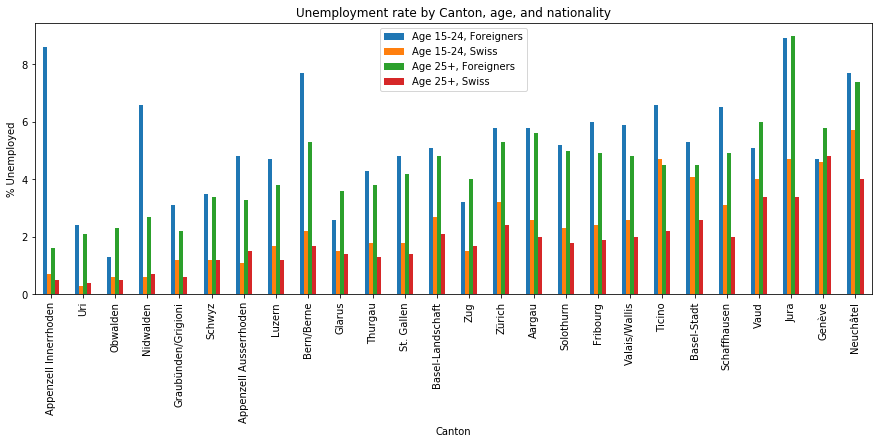

In [26]:
canton_ordered = ch_unemploy_rate_canton.sort_values(by="Ratio of Jobseekers")["Canton"]
ax = ch_unemploy_rate_canton_nationality_age.unstack().unstack().loc[canton_ordered].plot.bar(figsize=(15, 5), stacked=False)
ax.legend(['Age 15-24, Foreigners', 'Age 15-24, Swiss', 'Age 25+, Foreigners', 'Age 25+, Swiss'])
ax.set_ylabel('% Unemployed')
_ = ax.set_title('Unemployment rate by Canton, age, and nationality')

## Question 4
Using the map you have just built, and the geographical information contained in it, could you give a rough estimate of the difference in unemployment rates between the areas divided by the Röstigraben?

*"Röstigraben is a humorous term used to refer to the cultural boundary between German-speaking and French-speaking parts of Switzerland"* -- Wikipedia

![](https://upload.wikimedia.org/wikipedia/commons/9/9f/Map_Languages_CH.png)
According to the map above, the French-speaking cantons are: Valais, Fribourg, Genève, Vaud, Neuchâtel, Jura. The German-speaking cantons are all the others except Ticino.

In [27]:
french_speaking = set(['Valais', 'Fribourg', 'Genève', 'Vaud', 'Neuchâtel', 'Jura'])
italian_speaking = set(['Ticino'])
german_speaking = set(ch_unemployed['Canton']) - french_speaking - italian_speaking
print('German-speaking cantons:')
german_speaking

German-speaking cantons:


{'Aargau',
 'Appenzell Ausserrhoden',
 'Appenzell Innerrhoden',
 'Basel-Landschaft',
 'Basel-Stadt',
 'Bern/Berne',
 'Glarus',
 'Graubünden/Grigioni',
 'Luzern',
 'Nidwalden',
 'Obwalden',
 'Schaffhausen',
 'Schwyz',
 'Solothurn',
 'St. Gallen',
 'Thurgau',
 'Uri',
 'Valais/Wallis',
 'Zug',
 'Zürich'}

In [28]:
def get_language(canton):
    if canton in french_speaking:
        return "French"
    elif canton in german_speaking:
        return "German"
    else:
        return "Italian"
    
ch_unemployed['Language'] = ch_unemployed['Canton'].map(get_language)
by_language = ch_unemployed.groupby('Language')['Unemployed Jobseekers', 'Active Population'].sum()
by_language['Unemployment rate (%)'] = by_language['Unemployed Jobseekers']/by_language['Active Population']*100
by_language

,Unemployed Jobseekers,Active Population,Unemployment rate (%)
Language,,,
French,40212,925163,4.346477
German,87755,3420727,2.565390
Italian,5202,166025,3.133263


It appears that German-speaking Cantons have the lowest unemployment rate, and French-speaking Cantons the highest. Here, we also evaluated the *Polentagraben*, which refers to the difference between Italian-speaking Cantons (i.e. Ticino) and the others.